In [1]:
import numpy as np
from os import path

# from aicsimageio import AICSImage
# from aicspylibczi import CziFile
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
plt.style.use("../paper_style.mplstyle")
figwidth = 3.4

import pandas as pd
from skimage.io import imread
import yaml
from scipy.fft import dctn
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from basicpy.metrics import fourier_L0_norm

# from cucim.skimage.morphology import binary_erosion, disk

nuc_channel_idx = 2
cyto_channel_idx = 0


def save_and_copy_fig(fig, name):
    fig.savefig("../figs/" + name + ".pdf")
    !cp ../figs/{name}.pdf ~/myworks/papers/2305_BaSiCPy/fig2/

In [2]:
import glob

# file_path = "/content/drive/MyDrive/Colab Notebooks/BaSiCPy-dev/Simulation/simulatedimages/"
file_path = "./"
flatfield_true = np.load(
    path.join(file_path, f"flatfield_true.npy"),
)
darkfield_true = np.load(
    path.join(file_path, f"darkfield_true.npy"),
)
baseline_true = np.load(
    path.join(file_path, f"baseline_true.npy"),
)

In [3]:
with open("wo_darkfield_ground_truth_values.yaml", "r") as f:
    gt_values = yaml.safe_load(f)

# Without darkfield

In [4]:
images_distorted_wo_darkfield = np.load("images_distorted_wo_darkfield_with_noise.npy")
images_distorted_wo_darkfield.shape

(2, 200, 256, 256)

cp: cannot create regular file ‘/home/fukai/myworks/papers/2305_BaSiCPy/fig2/’: No such file or directory


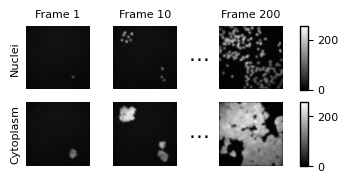

In [5]:
fig, axes = plt.subplots(
    2, 5, width_ratios=(1, 1, 0.1, 1, 0.1), figsize=(figwidth, figwidth / 2)
)
for ch, _axes in zip([0, 1], axes):
    _axes[0].imshow(images_distorted_wo_darkfield[ch, 0], cmap="gray", vmin=0, vmax=255)
    _axes[1].imshow(images_distorted_wo_darkfield[ch, 9], cmap="gray", vmin=0, vmax=255)
    im = _axes[3].imshow(
        images_distorted_wo_darkfield[ch, 199], cmap="gray", vmin=0, vmax=255
    )
    fig.colorbar(im, cax=_axes[4])

axes[0, 0].set_title("Frame 1")
axes[0, 1].set_title("Frame 10")
axes[0, 3].set_title("Frame 200")
axes[0, 0].set_ylabel("Nuclei")
axes[1, 0].set_ylabel("Cytoplasm")
for ax in axes[:, :-1].ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
for ax in axes[:, 2].ravel():
    ax.axis("off")
    ax.text(
        0.5,
        0.5,
        "$\cdots$",
        transform=ax.transAxes,
        ha="center",
        va="center",
        fontsize=15,
    )
fig.subplots_adjust(left=0.05, right=0.9, top=0.875, bottom=0.05)
save_and_copy_fig(fig, "fig2a_simulated_images_examples")

In [ ]:
flatfields_wo_darks = {}
baselines_wo_darks = {}
parameters_df_wo_darks = {}
for channel_index in [nuc_channel_idx, cyto_channel_idx]:
    flatfields_wo_darks[channel_index] = np.load(
        path.join(file_path, f"wo_darkfield_flatfields_channel_{channel_index}_2.npy"),
        allow_pickle=True,
    )
    baselines_wo_darks[channel_index] = np.load(
        path.join(file_path, f"wo_darkfield_baselines_channel_{channel_index}_2.npy"),
        allow_pickle=True,
    )
    parameters_df_wo_darks[channel_index] = pd.read_csv(
        path.join(file_path, f"wo_darkfield_parameters_channel_{channel_index}_2.csv"),
        index_col=0,
    )

: 

In [ ]:
plt.plot(baselines_wo_darks[0][0])

: 

In [8]:
print(parameters_df_wo_darks[0]["rep"].unique())
parameters_df_wo_darks[0].head()

[0 1 2 3 4]


,smoothness_flatfield,fitting_mode,sort_intensity,channel_index,use_weight,rep,entropy,fourier_L0_norm,autotune_cost,entropy2,autotune_cost2
0,0.001,ladmap,False,0,True,0,2.548107,0.326944,12.356438,4.005775,13.814107
1,0.001,ladmap,False,0,True,1,2.445715,0.326144,12.230030,4.007522,13.791837
2,0.001,ladmap,False,0,True,2,2.477198,0.323681,12.187617,4.006426,13.716845
3,0.001,ladmap,False,0,True,3,2.468213,0.321987,12.127829,4.007303,13.666918
4,0.001,ladmap,False,0,True,4,2.355932,0.321725,12.007696,4.006778,13.658542


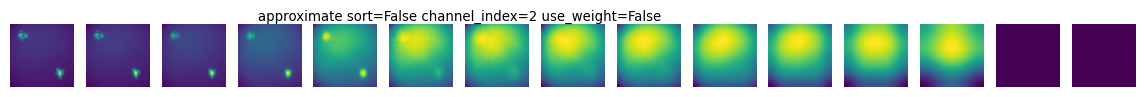

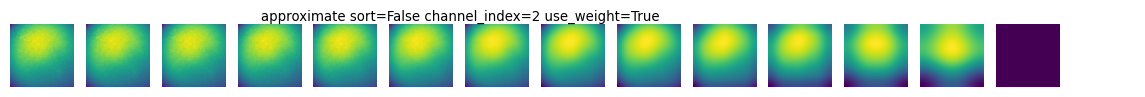

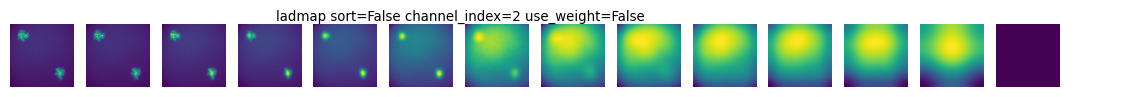

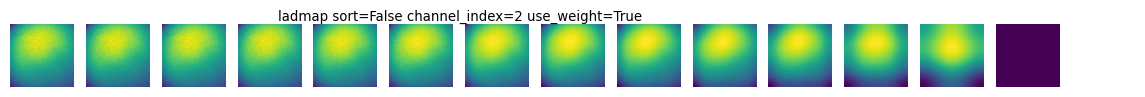

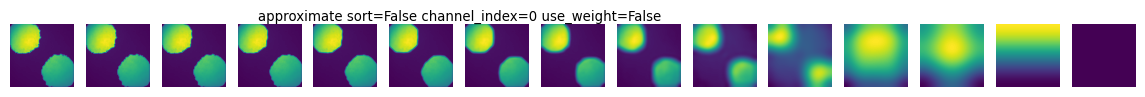

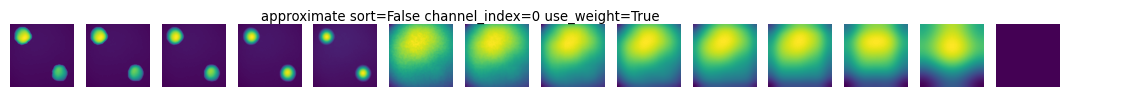

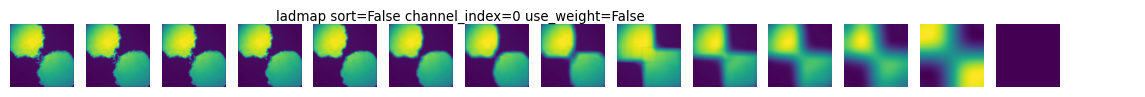

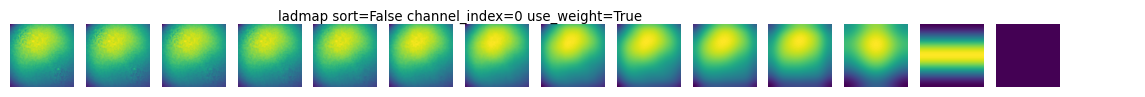

In [9]:
for channel_index in [nuc_channel_idx, cyto_channel_idx]:
    for (
        fitting_mode,
        sort_intensity,
        channel_index,
        use_weight,
    ), grp in parameters_df_wo_darks[channel_index].groupby(
        ["fitting_mode", "sort_intensity", "channel_index", "use_weight"]
    ):
        df = grp.sort_values("smoothness_flatfield").query("rep==0")
        fig, axes = plt.subplots(1, len(df), figsize=(15, 1))
        for ax, (i, row) in zip(np.ravel(axes), df.iterrows()):
            ax.imshow(flatfields_wo_darks[channel_index][i])
            ax.axis("off")
        fig.suptitle(
            f"{fitting_mode} sort={sort_intensity} channel_index={channel_index} use_weight={use_weight}"
        )
        fig.show()

In [10]:
df = parameters_df_wo_darks[nuc_channel_idx].query(
    "fitting_mode=='ladmap' and use_weight==True"
)
df = df.sort_values("smoothness_flatfield").query("rep==0")
df.index

Int64Index([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260,
            280],
           dtype='int64')

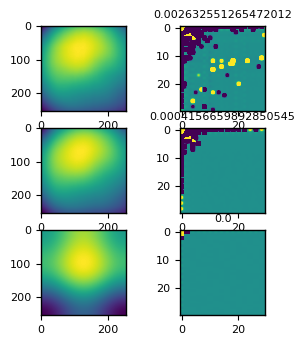

In [11]:
im0 = flatfields_wo_darks[nuc_channel_idx][df.index[7]]
im1 = flatfields_wo_darks[nuc_channel_idx][df.index[8]]
im2 = flatfields_wo_darks[nuc_channel_idx][df.index[-3]]
plt.subplot(321)
plt.imshow(im0)
plt.subplot(322)
plt.title(fourier_L0_norm(im0))
plt.imshow(dctn(im0)[:30, :30], vmin=-1, vmax=1)
plt.subplot(323)
plt.imshow(im1)
plt.subplot(324)
plt.title(fourier_L0_norm(im1))
plt.imshow(dctn(im1)[:30, :30], vmin=-1, vmax=1)
plt.subplot(325)
plt.imshow(im2)
plt.subplot(326)
plt.title(fourier_L0_norm(im2))
plt.imshow(dctn(im2)[:30, :30], vmin=-1, vmax=1);

In [12]:
for channel_index in [nuc_channel_idx, cyto_channel_idx]:
    for i, row in parameters_df_wo_darks[channel_index].iterrows():
        flatfield = flatfields_wo_darks[channel_index][i]
        if not np.any(np.isfinite(flatfield)):
            continue
        parameters_df_wo_darks[channel_index].loc[i, "mean_abs_error"] = np.mean(
            np.abs(flatfield_true - flatfield)
        )

In [13]:
gt_values

{'0_reference': {'autotune_cost': 4.059607933408433,
  'entropy': 2.6187836854363336,
  'fourier_L0_norm': 0.0},
 '0_true': {'autotune_cost': 10.004675912844355,
  'entropy': 2.7745992605793828,
  'fourier_L0_norm': 0.19967362522322804},
 '2_reference': {'autotune_cost': 3.1655545397082565,
  'entropy': 2.5420524294630513,
  'fourier_L0_norm': 0.0},
 '2_true': {'autotune_cost': 9.198388265040835,
  'entropy': 2.7321801286066045,
  'fourier_L0_norm': 0.19967362522322804}}

In [14]:
def to_autotune_cost(
    entropy_value, n, fourier_l0_norm_threshold, fourier_l0_norm_cost_coef
):
    if n < fourier_l0_norm_threshold:
        fourier_L0_norm_cost = 0
    else:
        fourier_L0_norm_cost = (
            n - fourier_l0_norm_threshold
        ) * fourier_l0_norm_cost_coef
    return entropy_value + fourier_L0_norm_cost


to_autotune_cost = np.vectorize(to_autotune_cost)

mean std, max and min deviation 0.0168785203401935 0.00012122852485672908 0.017078252135953213 0.016748115089034104
ladmap True 0.006507327243009757 True
ladmap False 0.024656596103571342 True
approximate True 0.00703103910118109 True
approximate False 0.02263398309920564 True
mean std, max and min deviation 0.013212893389015937 0.00016666105337208195 0.013472574237763026 0.01296487733442627
ladmap True 0.005744977450115754 True
ladmap False 0.17469444260939046 False
approximate True 0.007836840447130311 True
approximate False 0.05406173959098757 False
cp: cannot create regular file ‘/home/fukai/myworks/papers/2305_BaSiCPy/fig2/’: No such file or directory
cp: cannot create regular file ‘/home/fukai/myworks/papers/2305_BaSiCPy/fig2/’: No such file or directory


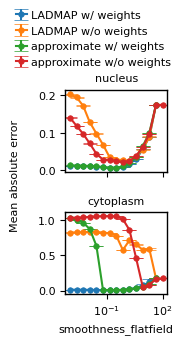

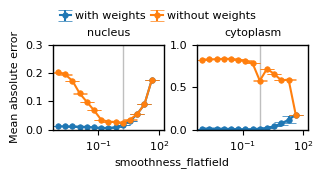

In [17]:
fig, axes = plt.subplots(
    2, 1, figsize=(3.4 / 2, 3.4), sharex=True, gridspec_kw=dict(hspace=0.5)
)
fig2, axes2 = plt.subplots(
    1, 2, figsize=(3.4, 3.4 / 2), sharex=True, gridspec_kw=dict(hspace=0.5, wspace=0.3)
)
range_maxes = {nuc_channel_idx: 0.3, cyto_channel_idx: 1.0}
for ax, ax2, channel_index in zip(axes, axes2, [nuc_channel_idx, cyto_channel_idx]):
    df = parameters_df_wo_darks[channel_index].query(
        f"sort_intensity==False and channel_index=={channel_index}"
    )
    df2 = (
        df.groupby(["fitting_mode", "use_weight", "smoothness_flatfield"])
        .agg(["mean", "std"])
        .reset_index()
    )
    for (fitting_mode, use_weight), grp in list(
        df2.groupby(["fitting_mode", "use_weight"])
    )[::-1]:
        xs = grp["smoothness_flatfield"]
        ys = grp["mean_abs_error"]["mean"]
        yerrs = grp["mean_abs_error"]["std"]
        ax.errorbar(
            xs,
            ys,
            yerrs,
            fmt="o-",
            label=f"{'LADMAP' if fitting_mode=='ladmap' else 'approximate'} {'w/' if use_weight else 'w/o'} weights",
        )
        if fitting_mode == "ladmap":
            ax2.errorbar(
                xs,
                ys,
                yerrs,
                fmt="o-",
                label=f"{'with' if use_weight else 'without'} weights",
            )

            if use_weight:
                df_plotted = df.query(
                    "fitting_mode==@fitting_mode and use_weight==@use_weight"
                ).copy()

                #                fourier_L0_norms = [
                #                    fourier_L0_norm(flatfields_wo_darks[channel_index][i])
                #                    for i in df_plotted.index]
                #
                #                ax2.plot(df_plotted["smoothness_flatfield"],fourier_L0_norms)
                # ax2.plot(df_plotted["smoothness_flatfield"],df_plotted["entropy"]-df_plotted["entropy"].min())

                df_plotted["autotune_cost_recalc"] = to_autotune_cost(
                    df_plotted["entropy2"], df_plotted["fourier_L0_norm"], 0, 30
                )
                optimal_smoothness_flatfields, optimal_mean_abs_error = [
                    np.array(
                        [
                            grp2.loc[grp2["autotune_cost_recalc"].idxmin(), k]
                            for rep, grp2 in df_plotted.groupby("rep")
                        ]
                    )
                    for k in ["smoothness_flatfield", "mean_abs_error"]
                ]

                m = np.mean(np.log(optimal_smoothness_flatfields))
                s = np.std(np.log(optimal_smoothness_flatfields))
                ax2.fill_betweenx(
                    [0, range_maxes[channel_index]],
                    np.min(optimal_smoothness_flatfields),
                    np.max(optimal_smoothness_flatfields),
                    # np.exp(m - s),
                    # np.exp(m + s),
                    alpha=0.5,
                    color="gray",
                )
                ax2.set_ylim(0, range_maxes[channel_index])
                # ax2_divider = make_axes_locatable(ax2)
                # Add an Axes above the main Axes.
                # cax2 = ax2_divider.append_axes("right", size="10%", pad="50%")
                # cax2.plot(np.ones_like(optimal_mean_abs_error),optimal_mean_abs_error,"o")
                print(
                    "mean std, max and min deviation",
                    optimal_mean_abs_error.mean(),
                    optimal_mean_abs_error.std(),
                    optimal_mean_abs_error.max(),
                    optimal_mean_abs_error.min(),
                )

        min_val = min(grp["mean_abs_error"]["mean"])
        print(fitting_mode, use_weight, min_val, min_val < 3e-2)
    for _ax in [ax, ax2]:
        _ax.set_xscale("log")
        # _ax.set_yscale("log")
        # _ax.set_ylim(0, None)
        _ax.set_title(
            {nuc_channel_idx: "nucleus", cyto_channel_idx: "cytoplasm"}[channel_index]
        )
        # _ax.axhline(gt_values[channel_index]["entropy"], color="gray", linestyle="--")
    # ax.axhline(2e-2)
fig.supylabel("Mean absolute error", x=0.025, fontsize=8.0)
axes2[0].set_ylabel("Mean absolute error", x=-0.2)
axes[1].set_xlabel("smoothness_flatfield")
fig2.supxlabel("smoothness_flatfield", fontsize=8.0, y=0.025, x=0.55)

axes[0].legend(loc="lower left", bbox_to_anchor=(-0.55, 1.2), handletextpad=0.4)
axes2[0].legend(
    loc="lower left",
    bbox_to_anchor=(0.0, 1.2),
    handletextpad=0.4,
    ncols=2,
    columnspacing=0.5,
)

fig.subplots_adjust(left=0.35, right=0.95, top=0.75, bottom=0.15)
fig2.subplots_adjust(left=0.2, right=0.95, top=0.75, bottom=0.25)

save_and_copy_fig(fig, "figS_simulated_images_flatfield_error_all")
save_and_copy_fig(fig2, "fig2b_simulated_images_flatfield_error")

approximate True 0.05406173959098757 False
ladmap True 0.05406173959098757 False
approximate True 0.05406173959098757 False
ladmap True 0.05406173959098757 False
cp: cannot create regular file ‘/home/fukai/myworks/papers/2305_BaSiCPy/fig2/’: No such file or directory
cp: cannot create regular file ‘/home/fukai/myworks/papers/2305_BaSiCPy/fig2/’: No such file or directory


approximate True 0.05406173959098757 False
ladmap True 0.05406173959098757 False
approximate True 0.05406173959098757 False
ladmap True 0.05406173959098757 False
cp: cannot create regular file ‘/home/fukai/myworks/papers/2305_BaSiCPy/fig2/’: No such file or directory
cp: cannot create regular file ‘/home/fukai/myworks/papers/2305_BaSiCPy/fig2/’: No such file or directory


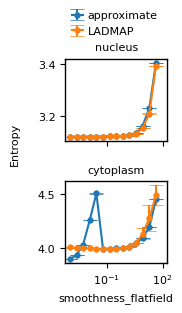

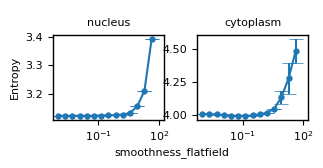

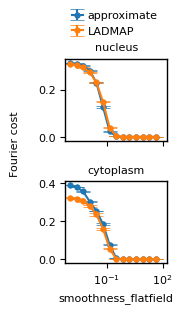

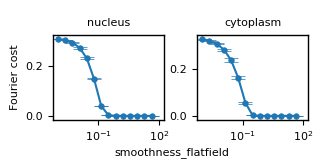

In [18]:
for key, name in [("entropy2", "Entropy"), ("fourier_L0_norm", "Fourier cost")]:

    fig, axes = plt.subplots(
        2, 1, figsize=(3.4 / 2, 3.4), sharex=True, gridspec_kw=dict(hspace=0.5)
    )
    fig2, axes2 = plt.subplots(
        1,
        2,
        figsize=(3.4, 3.4 / 2),
        sharex=True,
        gridspec_kw=dict(hspace=0.5, wspace=0.3),
    )
    for ax, ax2, channel_index in zip(axes, axes2, [nuc_channel_idx, cyto_channel_idx]):
        df = parameters_df_wo_darks[channel_index].query(
            f"sort_intensity==False and channel_index=={channel_index} and use_weight==True"
        )
        df2 = (
            df.groupby(["fitting_mode", "use_weight", "smoothness_flatfield"])
            .agg(["mean", "std"])
            .reset_index()
        )
        for (fitting_mode, use_weight), grp in df2.groupby(
            ["fitting_mode", "use_weight"]
        ):
            xs = grp["smoothness_flatfield"]
            ys = grp[key]["mean"]
            yerrs = grp[key]["std"]
            ax.errorbar(
                xs,
                ys,
                yerrs,
                fmt="o-",
                label=f"{'LADMAP' if fitting_mode=='ladmap' else 'approximate'}",
            )

            grp

            if fitting_mode == "ladmap":
                ax2.errorbar(
                    xs,
                    ys,
                    yerrs,
                    fmt="o-",
                    # label=f"{'with' if use_weight else 'without'} weights",
                )
            print(fitting_mode, use_weight, min_val, min_val < 3e-2)
        for _ax in [ax, ax2]:
            _ax.set_xscale("log")
            # _ax.set_yscale("log")
            # _ax.set_ylim(0,None)
            _ax.set_title(
                {nuc_channel_idx: "nucleus", cyto_channel_idx: "cytoplasm"}[
                    channel_index
                ]
            )
        # ax.axhline(2e-2)
    fig.supylabel(name, x=0.025, fontsize=8.0)
    axes2[0].set_ylabel(name, x=-0.2)
    axes[1].set_xlabel("smoothness_flatfield")
    fig2.supxlabel("smoothness_flatfield", fontsize=8.0, y=0.025, x=0.55)

    axes[0].legend(loc="lower left", bbox_to_anchor=(0.0, 1.2), handletextpad=0.4)
    axes2[0].legend(
        loc="lower left",
        bbox_to_anchor=(0.0, 1.2),
        handletextpad=0.4,
        ncols=2,
        columnspacing=0.5,
    )

    # axes[0].axhline(gt_values[nuc_channel_idx]["entropy"], color="gray")

    fig.subplots_adjust(left=0.35, right=0.95, top=0.75, bottom=0.15)
    fig2.subplots_adjust(left=0.2, right=0.95, top=0.75, bottom=0.25)

    if key == "entropy":
        save_and_copy_fig(fig, "figS_simulated_images_flatfield_entropy_all")
        save_and_copy_fig(fig2, "fig2c_simulated_images_flatfield_entropy")
    else:
        save_and_copy_fig(fig, f"figS_simulated_images_flatfield_{key}_all")
        save_and_copy_fig(fig2, f"figS_simulated_images_flatfield_{key}")